<p style="background:#83739E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b>Risk Evaluation for Retail Banks</b><br>
    <br>Exploratory Data Analysis - Other Datasets<br><br> 
</p>

<p style="text-align: right;">Module 4: Machine Learning<br>
Sprint 4: Machine Learning Capstone Project<br>
Author : Renato Mariano</p>

<h1 style="color:#774CAD">Introduction </h1>

Welcome to the Capstone Project of of the Machine Learning Module! In this sprint, we embark on an exciting journey to develop a **risk evaluation service for retail banks**, leveraging the power of data science and machine learning.

This work is part of a series of notebooks starting with 01_EDA_application.

In the previous notebook, **we engineered some features** for the Application Data, obtaining a **ROC AUC score of 0.728** for our XGBoost. Now it is time to **shortly evaluate some of the other datasets**.

<h2 style="color:#774CAD">Library Imports and Notebook Setup</h2>

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from rapidfuzz import process

import utils
import EDA

In [37]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext blackcellmagic

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


<h1 style="color:#774CAD">Exploratory Data Analysis</h1>

Initial read of application train data and columns information.

In [38]:
col_info = utils.load_df(file_path="data/home-credit-default-risk/HomeCredit_columns_description.csv", encoding='unicode_escape')
df_train = utils.load_df(file_path="data/df_train.csv")

The shape of the data is: (219, 5)
load_df took 0.220 seconds

The shape of the data is: (153755, 122)
load_df took 4.699 seconds



<h2 style="color:#774CAD">Previous Applications</h2>

Let's take a look at the previous application dataframe to check how it looks like.

In [4]:
df_previous = utils.load_df(file_path="data/home-credit-default-risk/previous_application.csv")
df_previous.head(5)

The shape of the data is: (1670214, 37)
load_df took 15.854 seconds



,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.000,17145.000,0.000,17145.000,SATURDAY,15,...,Connectivity,12.000,middle,POS mobile with interest,365243.000,-42.000,300.000,-42.000,-37.000,0.000
1,2802425,108129,Cash loans,25188.615,607500.000,679671.000,NaN,607500.000,THURSDAY,11,...,XNA,36.000,low_action,Cash X-Sell: low,365243.000,-134.000,916.000,365243.000,365243.000,1.000
2,2523466,122040,Cash loans,15060.735,112500.000,136444.500,NaN,112500.000,TUESDAY,11,...,XNA,12.000,high,Cash X-Sell: high,365243.000,-271.000,59.000,365243.000,365243.000,1.000
3,2819243,176158,Cash loans,47041.335,450000.000,470790.000,NaN,450000.000,MONDAY,7,...,XNA,12.000,middle,Cash X-Sell: middle,365243.000,-482.000,-152.000,-182.000,-177.000,1.000
4,1784265,202054,Cash loans,31924.395,337500.000,404055.000,NaN,337500.000,THURSDAY,9,...,XNA,24.000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


How many columns are not in the training dataset and which ones can be found in both?

In [5]:
print(f"Columns in df_previous but not in df_train:{df_previous.columns.difference(df_train.columns).size}\n") 

print(f"Common columns between df_train and df_previous:{df_train.columns.intersection(df_previous.columns)}") 

Columns in df_previous but not in df_train:29

Common columns between df_train and df_previous:Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START'],
      dtype='object')


In [6]:
print(f"There are {df_previous['SK_ID_CURR'].nunique()} unique current ID values in previous application and {df_train['SK_ID_CURR'].nunique()} in the current.\n")

not_in_previous = df_train['SK_ID_CURR'][~df_train['SK_ID_CURR'].isin(df_previous['SK_ID_CURR'])]
print(f"{not_in_previous.size} clients did not make a previous application")

There are 338857 unique current ID values in previous application and 153755 in the current.

8139 clients did not make a previous application


In [7]:
df_info = EDA.custom_info(df_previous)
df_info[df_info["dtype"] == "object"].drop(["Min", "Mean", "Max", "Std"], axis=1)

Shape: (1670214, 37)



,dtype,%Nulls,#Unique,top_values,top_counts,top_ratios
NAME_CONTRACT_TYPE,object,0.000,4,"['Cash loans', 'Consumer loans', 'Revolving lo...","[747553, 729151, 193164, 346]","[0.45, 0.44, 0.12, 0.0]"
WEEKDAY_APPR_PROCESS_START,object,0.000,7,"['TUESDAY', 'WEDNESDAY', 'MONDAY', 'FRIDAY', '...","[255118, 255010, 253557, 252048, 249099]","[0.15, 0.15, 0.15, 0.15, 0.15]"
FLAG_LAST_APPL_PER_CONTRACT,object,0.000,2,"['Y', 'N']","[1661739, 8475]","[0.99, 0.01]"
NAME_CASH_LOAN_PURPOSE,object,0.000,25,"['XAP', 'XNA', 'Repairs', 'Other', 'Urgent nee...","[922661, 677918, 23765, 15608, 8412]","[0.55, 0.41, 0.01, 0.01, 0.01]"
NAME_CONTRACT_STATUS,object,0.000,4,"['Approved', 'Canceled', 'Refused', 'Unused of...","[1036781, 316319, 290678, 26436]","[0.62, 0.19, 0.17, 0.02]"
NAME_PAYMENT_TYPE,object,0.000,4,"['Cash through the bank', 'XNA', 'Non-cash fro...","[1033552, 627384, 8193, 1085]","[0.62, 0.38, 0.0, 0.0]"
CODE_REJECT_REASON,object,0.000,9,"['XAP', 'HC', 'LIMIT', 'SCO', 'CLIENT']","[1353093, 175231, 55680, 37467, 26436]","[0.81, 0.1, 0.03, 0.02, 0.02]"
NAME_TYPE_SUITE,object,49.120,7,"['Unaccompanied', 'Family', 'Spouse, partner',...","[508970, 213263, 67069, 31566, 17624]","[0.3, 0.13, 0.04, 0.02, 0.01]"
NAME_CLIENT_TYPE,object,0.000,4,"['Repeater', 'New', 'Refreshed', 'XNA']","[1231261, 301363, 135649, 1941]","[0.74, 0.18, 0.08, 0.0]"
NAME_GOODS_CATEGORY,object,0.000,28,"['XNA', 'Mobile', 'Consumer Electronics', 'Com...","[950809, 224708, 121576, 105769, 99441]","[0.57, 0.13, 0.07, 0.06, 0.06]"


In [8]:
df_info[(df_info["dtype"] == "int64") | (df_info["dtype"] == "float64")]

,dtype,%Nulls,#Unique,Min,Mean,Max,Std,top_values,top_counts,top_ratios
SK_ID_PREV,int64,0.000,1670214,1000001.000,1923089.135,2845382.000,532597.959,"[2030495, 1035848, 1526498, 2148893, 2437429]","[1, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 0.0]"
SK_ID_CURR,int64,0.000,338857,100001.000,278357.174,456255.000,102814.824,"[187868, 265681, 173680, 242412, 206783]","[77, 73, 72, 68, 67]","[0.0, 0.0, 0.0, 0.0, 0.0]"
AMT_ANNUITY,float64,22.287,357959,0.000,15955.121,418058.145,14782.137,"[2250.0, 11250.0, 6750.0, 9000.0, 22500.0]","[31865, 13974, 13442, 12496, 11903]","[0.02, 0.01, 0.01, 0.01, 0.01]"
AMT_APPLICATION,float64,0.000,93885,0.000,175233.860,6905160.000,292779.762,"[0.0, 45000.0, 225000.0, 135000.0, 450000.0]","[392402, 47831, 43543, 40678, 38905]","[0.23, 0.03, 0.03, 0.02, 0.02]"
AMT_CREDIT,float64,0.000,86803,0.000,196114.021,6905160.000,318574.617,"[0.0, 45000.0, 225000.0, 450000.0, 135000.0]","[336768, 35051, 21094, 19954, 18720]","[0.2, 0.02, 0.01, 0.01, 0.01]"
AMT_DOWN_PAYMENT,float64,53.636,29278,-0.900,6697.402,3060045.000,20921.495,"[0.0, 4500.0, 9000.0, 13500.0, 22500.0]","[369854, 21241, 14747, 9655, 8165]","[0.22, 0.01, 0.01, 0.01, 0.0]"
AMT_GOODS_PRICE,float64,23.082,93885,0.000,227847.279,6905160.000,315396.558,"[45000.0, 225000.0, 135000.0, 450000.0, 90000.0]","[47831, 43549, 40666, 38926, 29367]","[0.03, 0.03, 0.02, 0.02, 0.02]"
HOUR_APPR_PROCESS_START,int64,0.000,24,0.000,12.484,23.000,3.334,"[11, 12, 10, 13, 14]","[192728, 185980, 181690, 172256, 157711]","[0.12, 0.11, 0.11, 0.1, 0.09]"
NFLAG_LAST_APPL_IN_DAY,int64,0.000,2,0.000,0.996,1.000,0.059,"[1, 0]","[1664314, 5900]","[1.0, 0.0]"
RATE_DOWN_PAYMENT,float64,53.636,207033,-0.000,0.080,1.000,0.108,"[0.0, 0.1089090909090909, 0.2178181818181818, ...","[369854, 36341, 6482, 1081, 746]","[0.22, 0.02, 0.0, 0.0, 0.0]"


We can evaluate the quantity of previous applications that each client has made. Some other interesting features that we can compute are the quantity of rejected/accepted/cancelled application that were made for each client.

In [9]:
previous_loan_counts = df_previous.groupby('SK_ID_CURR').size().reset_index().rename(columns = {0: 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [10]:
pivot_table = df_previous.pivot_table(index='SK_ID_CURR', columns='NAME_CONTRACT_STATUS', aggfunc='size')
pivot_table.columns = [f"NAME_CONTRACT_{status.lower().replace(' ', '_')}" for status in pivot_table.columns]
pivot_table.reset_index(inplace=True)
pivot_table.head()

,SK_ID_CURR,NAME_CONTRACT_approved,NAME_CONTRACT_canceled,NAME_CONTRACT_refused,NAME_CONTRACT_unused_offer
0,100001,1.000,NaN,NaN,NaN
1,100002,1.000,NaN,NaN,NaN
2,100003,3.000,NaN,NaN,NaN
3,100004,1.000,NaN,NaN,NaN
4,100005,1.000,1.000,NaN,NaN


In [11]:
previous_loan_counts = previous_loan_counts.merge(pivot_table, on="SK_ID_CURR")
previous_loan_counts.describe()

,SK_ID_CURR,previous_loan_counts,NAME_CONTRACT_approved,NAME_CONTRACT_canceled,NAME_CONTRACT_refused,NAME_CONTRACT_unused_offer
count,338857.000,338857.000,337698.000,132694.000,118277.000,22079.000
mean,278149.910,4.929,3.070,2.384,2.458,1.197
std,102879.193,4.221,2.132,2.031,2.381,0.558
min,100001.000,1.000,1.000,1.000,1.000,1.000
25%,189061.000,2.000,1.000,1.000,1.000,1.000
50%,278221.000,4.000,3.000,2.000,2.000,1.000
75%,367302.000,7.000,4.000,3.000,3.000,1.000
max,456255.000,77.000,27.000,58.000,68.000,21.000


Now we have our previous loans counts that can be merged to the application dataframe to compute new predictions, we will implement this on our pipeline.

Before moving further, let's evaluate the quantity of null values in the datatable.

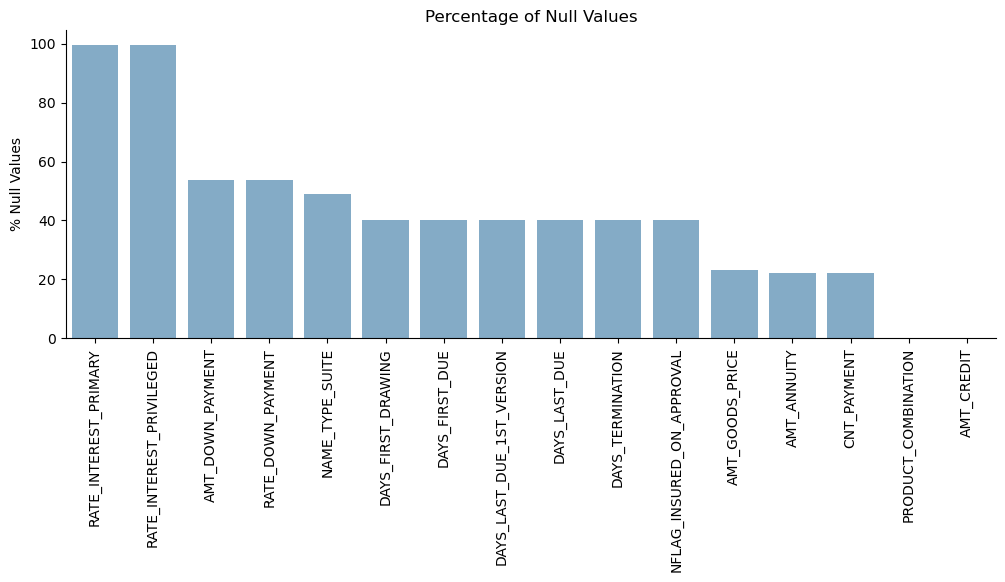

In [12]:
missing_df = pd.DataFrame(df_info[df_info["%Nulls"] > 0]["%Nulls"].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(
    data=missing_df,
    y="%Nulls",
    x=missing_df.index,
    color="tab:blue",
    alpha=0.6,
    ax=ax,
)
ax.set(ylabel="% Null Values", xlabel="", title="Percentage of Null Values")
sns.despine()
plt.xticks(rotation=90);

Some of the features have almost 100% null values and should definitely not be taken to the model.

Let's visualize the numerical data to get a better overview of the features.

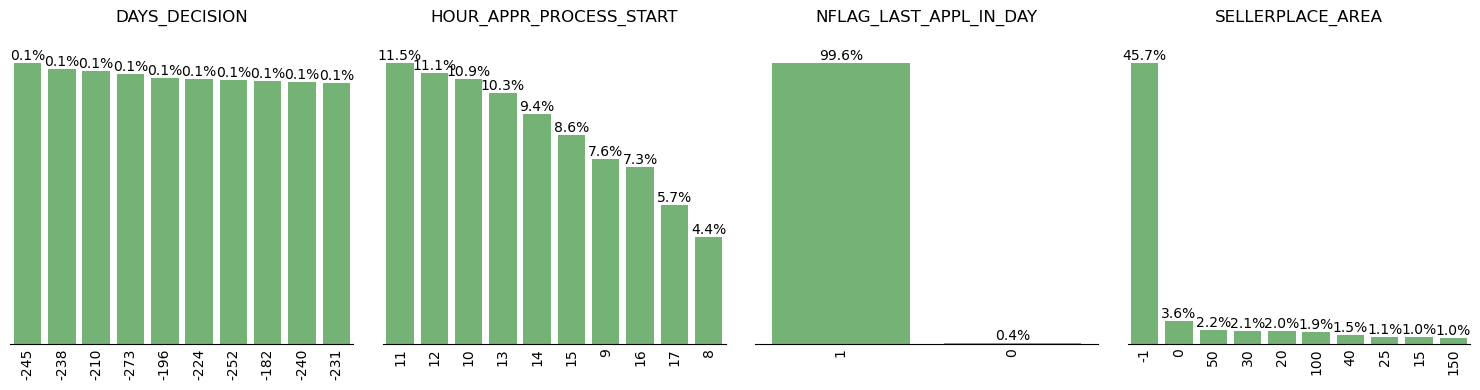

In [13]:
int_feats = df_info[(df_info["dtype"] == "int64")]["dtype"].index
int_feats_cleaned = int_feats[:21].difference(['SK_ID_CURR', 'SK_ID_PREV'])
EDA.plot_categories(df_previous, int_feats_cleaned, fig_x=15, fig_y=4, top_n=10, color='tab:green')

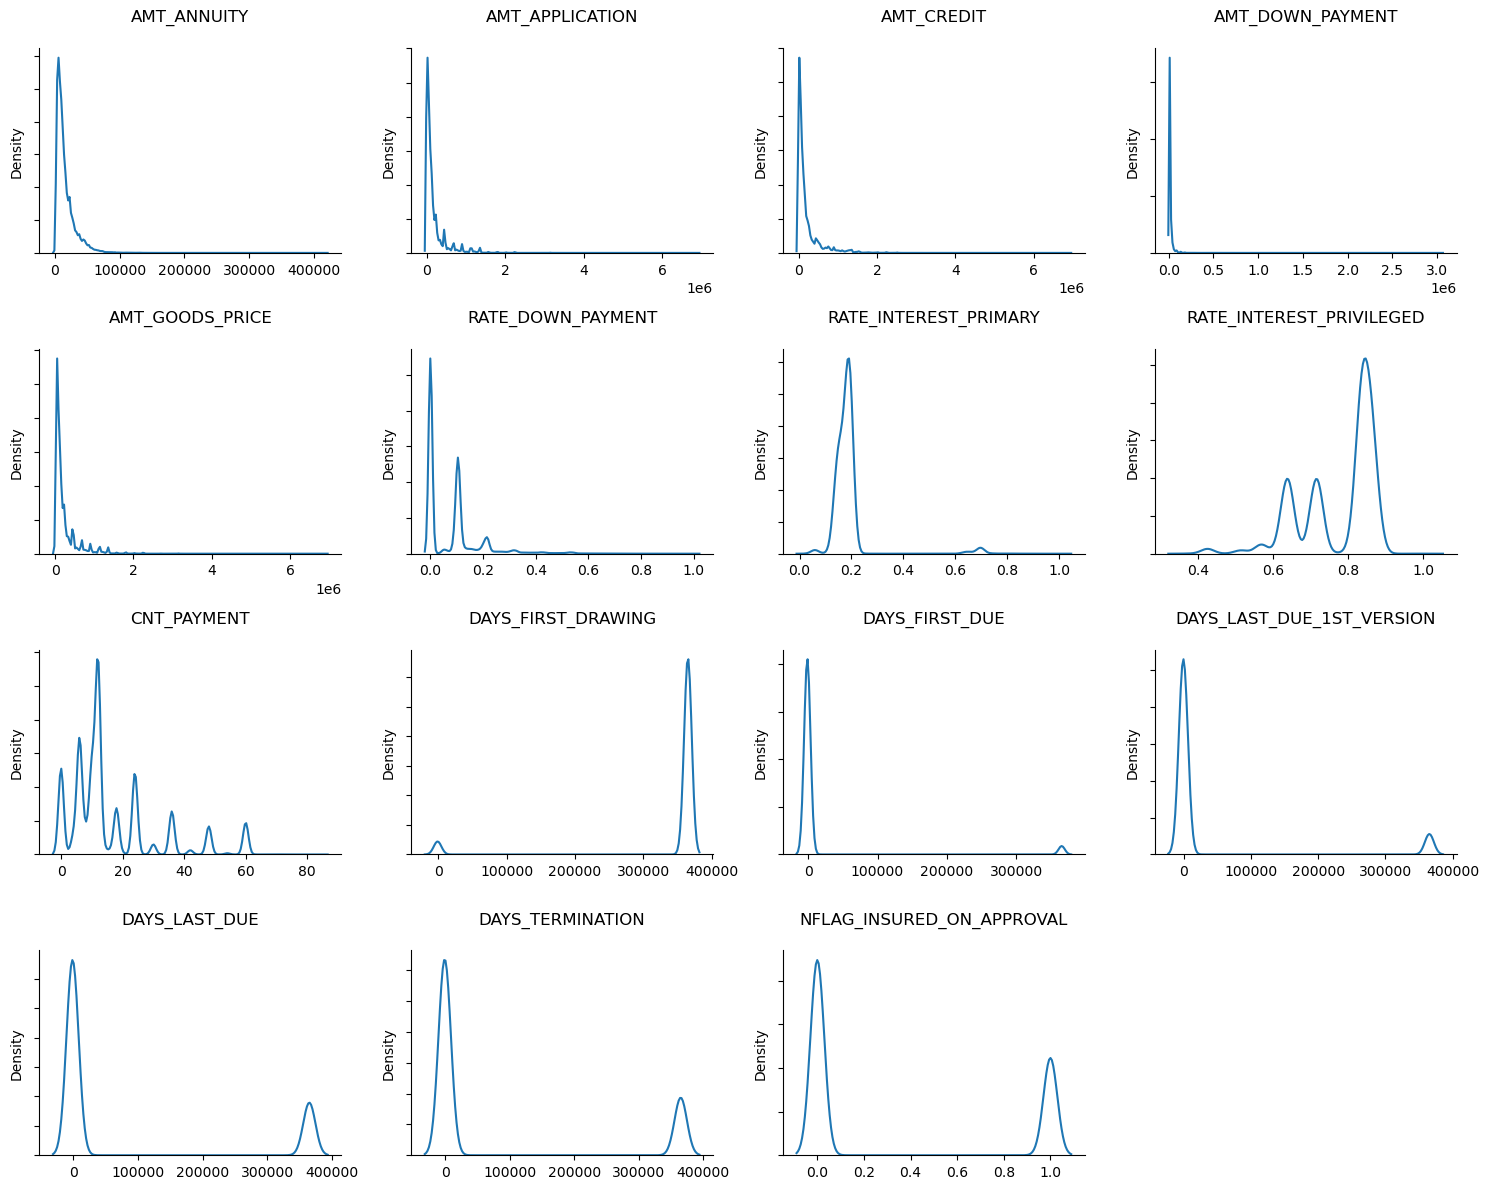

In [14]:
cont_feats = df_info[(df_info["dtype"] == "float64")]["dtype"].index

EDA.plot_continuous(df_previous, cont_feats, fig_x=15, fig_y=12, color='tab:purple')

Another feature that can bring some more information to our model, would be the rate of the down payment in relation to the total amount of the good to be acquired ("RATE_DOWN_PAYMENT"). We will aggregate for this feature the median, max and min values.

In [15]:
result_df = df_previous.groupby("SK_ID_CURR")["RATE_DOWN_PAYMENT"].agg(["median", "max", "min"]).reset_index()
result_df.columns = ["SK_ID_CURR", "RATE_DOWN_PAYMENT_Median", "RATE_DOWN_PAYMENT_Max", "RATE_DOWN_PAYMENT_Min"]
result_df.head()

,SK_ID_CURR,RATE_DOWN_PAYMENT_Median,RATE_DOWN_PAYMENT_Max,RATE_DOWN_PAYMENT_Min
0,100001,0.104,0.104,0.104
1,100002,0.000,0.000,0.000
2,100003,0.050,0.100,0.000
3,100004,0.212,0.212,0.212
4,100005,0.109,0.109,0.109


For now, we will use on our model only the recently created counts and the rate_down_payments. Let's evaluate now some more of the other dataframes.

<h2 style="color:#774CAD">Installment Data</h2>

In [39]:
df_installments = utils.load_df(file_path="data/home-credit-default-risk/installments_payments.csv")
df_installments.head(5)

The shape of the data is: (13605401, 8)
load_df took 30.564 seconds



,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.000,6,-1180.000,-1187.000,6948.360,6948.360
1,1330831,151639,0.000,34,-2156.000,-2156.000,1716.525,1716.525
2,2085231,193053,2.000,1,-63.000,-63.000,25425.000,25425.000
3,2452527,199697,1.000,3,-2418.000,-2426.000,24350.130,24350.130
4,2714724,167756,1.000,2,-1383.000,-1366.000,2165.040,2160.585


The dataframe contains a small percentage of null values.

In [40]:
df_installments.isna().sum()*100/df_installments.shape[0]

SK_ID_PREV               0.000
SK_ID_CURR               0.000
NUM_INSTALMENT_VERSION   0.000
NUM_INSTALMENT_NUMBER    0.000
DAYS_INSTALMENT          0.000
DAYS_ENTRY_PAYMENT       0.021
AMT_INSTALMENT           0.000
AMT_PAYMENT              0.021
dtype: float64

In [42]:
df_info = EDA.custom_info(df_installments)
df_info

Shape: (13605401, 8)



,dtype,%Nulls,#Unique,Min,Mean,Max,Std,top_values,top_counts,top_ratios
SK_ID_PREV,int64,0.000,997752,1000001.000,1903364.970,2843499.000,536202.906,"[2360056, 2592574, 1017477, 1449382, 1746731]","[293, 279, 248, 243, 236]","[0.0, 0.0, 0.0, 0.0, 0.0]"
SK_ID_CURR,int64,0.000,339587,100001.000,278444.882,456255.000,102718.310,"[145728, 296205, 453103, 189699, 186851]","[372, 350, 347, 344, 337]","[0.0, 0.0, 0.0, 0.0, 0.0]"
NUM_INSTALMENT_VERSION,float64,0.000,65,0.000,0.857,178.000,1.035,"[1.0, 0.0, 2.0, 3.0, 4.0]","[8485004, 4082498, 620283, 237063, 55274]","[0.62, 0.3, 0.05, 0.02, 0.0]"
NUM_INSTALMENT_NUMBER,int64,0.000,277,1.000,18.871,277.000,26.664,"[1, 2, 3, 4, 5]","[1004160, 985716, 968279, 943502, 880007]","[0.07, 0.07, 0.07, 0.07, 0.06]"
DAYS_INSTALMENT,float64,0.000,2922,-2922.000,-1042.270,-1.000,800.946,"[-120.0, -180.0, -150.0, -119.0, -149.0]","[11512, 11212, 11194, 11183, 11144]","[0.0, 0.0, 0.0, 0.0, 0.0]"
DAYS_ENTRY_PAYMENT,float64,0.021,3039,-4921.000,-1051.114,-1.000,800.586,"[-91.0, -182.0, -154.0, -92.0, -245.0]","[13103, 13090, 13071, 12646, 12405]","[0.0, 0.0, 0.0, 0.0, 0.0]"
AMT_INSTALMENT,float64,0.000,902539,0.000,17050.907,3771487.845,50570.254,"[9000.0, 2250.0, 4500.0, 6750.0, 3375.0]","[254062, 179120, 174143, 173659, 149941]","[0.02, 0.01, 0.01, 0.01, 0.01]"
AMT_PAYMENT,float64,0.021,944235,0.000,17238.223,3771487.845,54735.784,"[9000.0, 2250.0, 4500.0, 6750.0, 3375.0]","[248757, 182654, 178309, 170360, 141832]","[0.02, 0.01, 0.01, 0.01, 0.01]"


By the description of the features, we can compute some interesting new ones.

The first will be the ratio of paid value by installment value (which we can create aggregates), from this we can also flag if the clients ever paid less.
The second will be the quatity of delayed days of a payment (here also aggregates for each client), and a flag if client has ever delayed a payment.

Later on, we also created a feature to flag the quantity of delayed days, but only for the first year of loan (DAYS_INSTALLMENT >= -365). This might highlight the behaviour of clients on the first year of a loan.

We will generate these features directly on the next notebook.

In [41]:
col_info[(col_info["Table"] == "installments_payments.csv")]

,Unnamed: 0,Table,Row,Description,Special
211,214,installments_payments.csv,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
212,215,installments_payments.csv,SK_ID_CURR,ID of loan in our sample,hashed
213,216,installments_payments.csv,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...,NaN
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN
218,221,installments_payments.csv,AMT_PAYMENT,What the client actually paid on previous cred...,NaN


In [19]:
col_info[(col_info["Table"] == "installments_payments.csv")]["Description"][215]

'When the installment of previous credit was supposed to be paid (relative to application date of current loan)'

In [20]:
col_info[(col_info["Table"] == "installments_payments.csv")]["Description"][216]

'When was the installments of previous credit paid actually (relative to application date of current loan)'

<h2 style="color:#774CAD">Bureau</h2>

Let's take a look at the previous application dataframe to check how it looks like.

In [21]:
df_bureau = utils.load_df(file_path="data/home-credit-default-risk/bureau.csv")
df_bureau.head(5)

The shape of the data is: (1716428, 17)
load_df took 5.880 seconds



,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.000,-153.000,NaN,0,91323.000,0.000,NaN,0.000,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.000,NaN,NaN,0,225000.000,171342.000,NaN,0.000,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.000,NaN,NaN,0,464323.500,NaN,NaN,0.000,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.000,NaN,NaN,0.000,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.000,NaN,77674.500,0,2700000.000,NaN,NaN,0.000,Consumer credit,-21,NaN


How many columns are not in the training dataset and which ones can be found in both?

In [22]:
print(f"Columns in df_bureau but not in df_train:{df_bureau.columns.difference(df_train.columns).size}\n") 

print(f"Common columns between df_train and df_bureau:{df_train.columns.intersection(df_bureau.columns)}") 

Columns in df_bureau but not in df_train:15

Common columns between df_train and df_bureau:Index(['SK_ID_CURR', 'AMT_ANNUITY'], dtype='object')


In [23]:
print(f"There are {df_bureau['SK_ID_CURR'].nunique()} unique current ID values in bureau dataframe and {df_train['SK_ID_CURR'].nunique()} in the current.\n")

not_in_previous = df_train['SK_ID_CURR'][~df_train['SK_ID_CURR'].isin(df_bureau['SK_ID_CURR'])]
print(f"{not_in_previous.size} clients did not make a application in bureau")

There are 305811 unique current ID values in bureau dataframe and 153755 in the current.

22195 clients did not make a application in bureau


In [24]:
df_info = EDA.custom_info(df_bureau)
df_info[df_info["dtype"] == "object"].drop(["Min", "Mean", "Max", "Std"], axis=1)

Shape: (1716428, 17)



,dtype,%Nulls,#Unique,top_values,top_counts,top_ratios
CREDIT_ACTIVE,object,0.000,4,"['Closed', 'Active', 'Sold', 'Bad debt']","[1079273, 630607, 6527, 21]","[0.63, 0.37, 0.0, 0.0]"
CREDIT_CURRENCY,object,0.000,4,"['currency 1', 'currency 2', 'currency 3', 'cu...","[1715020, 1224, 174, 10]","[1.0, 0.0, 0.0, 0.0]"
CREDIT_TYPE,object,0.000,15,"['Consumer credit', 'Credit card', 'Car loan',...","[1251615, 402195, 27690, 18391, 12413]","[0.73, 0.23, 0.02, 0.01, 0.01]"


In [25]:
df_info[(df_info["dtype"] == "int64") | (df_info["dtype"] == "float64")]

,dtype,%Nulls,#Unique,Min,Mean,Max,Std,top_values,top_counts,top_ratios
SK_ID_CURR,int64,0.000,305811,100001.000,278214.934,456255.000,102938.558,"[120860, 169704, 318065, 251643, 425396]","[116, 94, 78, 61, 60]","[0.0, 0.0, 0.0, 0.0, 0.0]"
SK_ID_BUREAU,int64,0.000,1716428,5000000.000,5924434.489,6843457.000,532265.729,"[5714462, 6758530, 6758496, 6758495, 6758494]","[1, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 0.0]"
DAYS_CREDIT,int64,0.000,2923,-2922.000,-1142.108,0.000,795.165,"[-364, -336, -273, -357, -343]","[1330, 1248, 1238, 1218, 1203]","[0.0, 0.0, 0.0, 0.0, 0.0]"
CREDIT_DAY_OVERDUE,int64,0.000,942,0.000,0.818,2792.000,36.544,"[0, 30, 60, 8, 13]","[1712211, 311, 126, 103, 103]","[1.0, 0.0, 0.0, 0.0, 0.0]"
DAYS_CREDIT_ENDDATE,float64,6.150,14096,-42060.000,510.517,31199.000,4994.220,"[0.0, 3.0, -7.0, 1.0, -14.0]","[883, 845, 837, 830, 787]","[0.0, 0.0, 0.0, 0.0, 0.0]"
DAYS_ENDDATE_FACT,float64,36.917,2917,-42023.000,-1017.437,0.000,714.011,"[-329.0, -273.0, -301.0, -91.0, -84.0]","[811, 794, 791, 785, 783]","[0.0, 0.0, 0.0, 0.0, 0.0]"
AMT_CREDIT_MAX_OVERDUE,float64,65.513,68251,0.000,3825.418,115987185.000,206031.606,"[0.0, 1440.0, 225.0, 45.0, 4.5]","[470650, 688, 405, 377, 315]","[0.27, 0.0, 0.0, 0.0, 0.0]"
CNT_CREDIT_PROLONG,int64,0.000,10,0.000,0.006,9.000,0.096,"[0, 1, 2, 3, 4]","[1707314, 7620, 1222, 191, 54]","[0.99, 0.0, 0.0, 0.0, 0.0]"
AMT_CREDIT_SUM,float64,0.001,236708,0.000,354994.592,585000000.000,1149811.344,"[0.0, 225000.0, 135000.0, 450000.0, 90000.0]","[66582, 57608, 50195, 37156, 36940]","[0.04, 0.03, 0.03, 0.02, 0.02]"
AMT_CREDIT_SUM_DEBT,float64,15.012,226537,-4705600.320,137085.120,170100000.000,677401.131,"[0.0, 4.5, -450.0, 135000.0, 90000.0]","[1016434, 653, 543, 344, 320]","[0.59, 0.0, 0.0, 0.0, 0.0]"


Let's check for null values in the datatable.

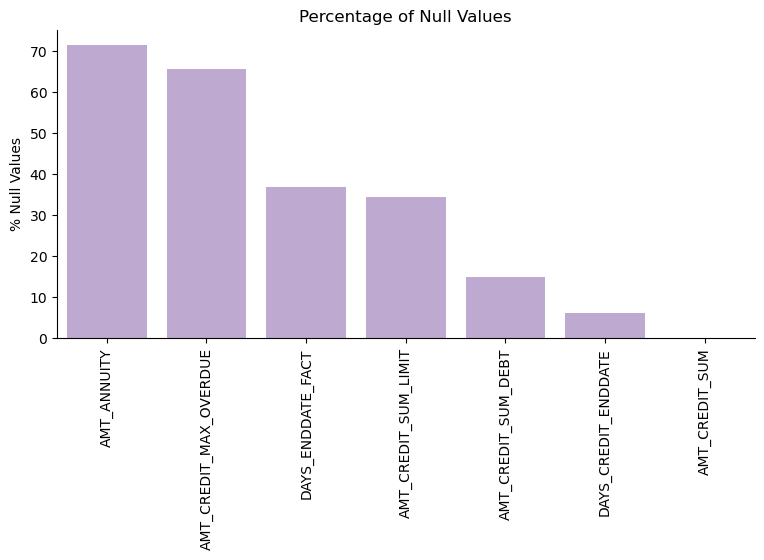

In [26]:
missing_df = pd.DataFrame(df_info[df_info["%Nulls"] > 0]["%Nulls"].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(9, 4))
sns.barplot(
    data=missing_df,
    y="%Nulls",
    x=missing_df.index,
    color="tab:purple",
    alpha=0.6,
    ax=ax,
)
ax.set(ylabel="% Null Values", xlabel="", title="Percentage of Null Values")
sns.despine()
plt.xticks(rotation=90);

Some of the features have almost 100% null values and should definitely not be taken to the model.

Let's visualize the numerical data to get a better overview of the features.

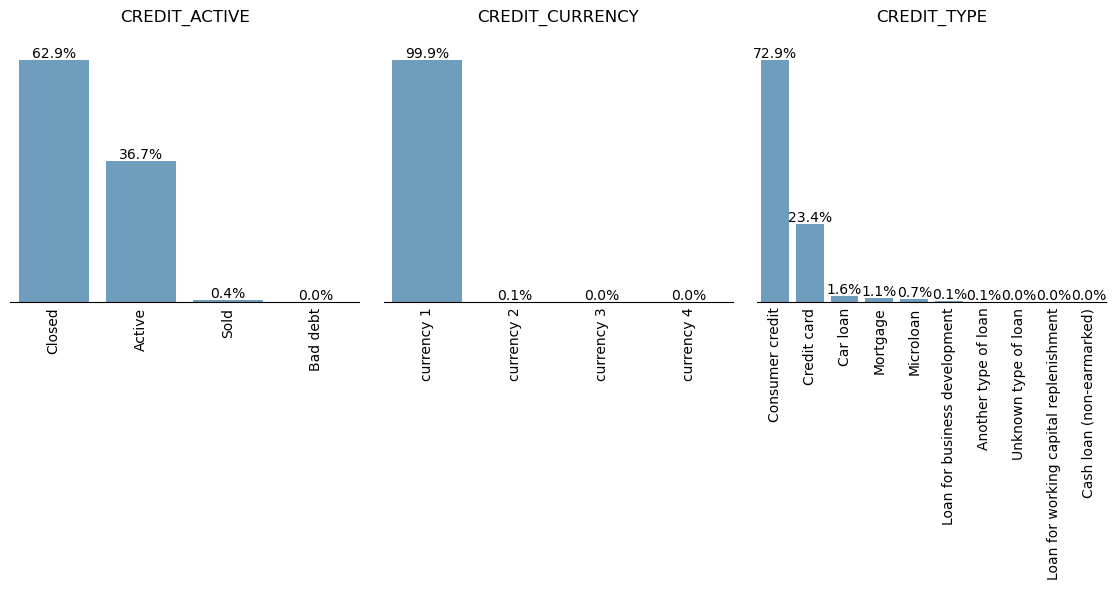

In [27]:
cat_feats = df_info[(df_info["dtype"] == "object")]["dtype"].index
EDA.plot_categories(df_bureau, cat_feats, fig_x=15, fig_y=6, top_n=10, color='tab:blue')

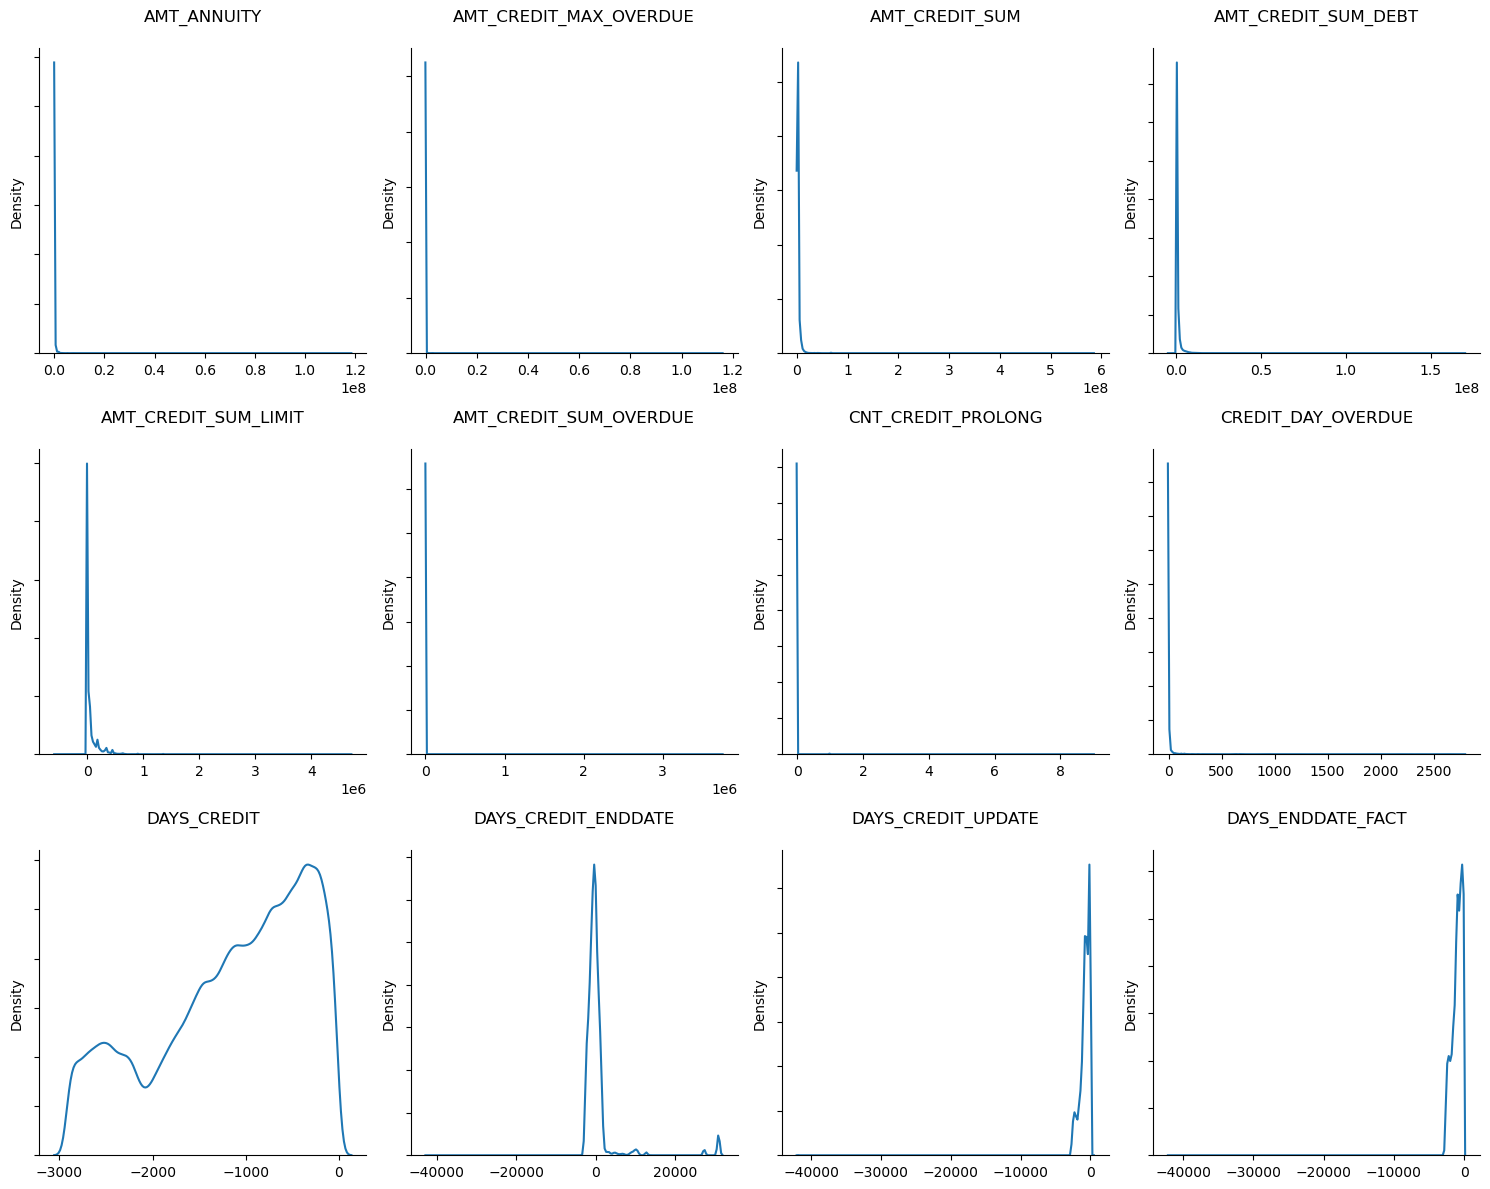

In [28]:
num_feats = df_info[(df_info["dtype"] == "float64") | (df_info["dtype"] == "int64")]["dtype"].index
EDA.plot_continuous(df_bureau, num_feats.difference(['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU']), fig_x=15, fig_y=12, color='tab:purple')

In the bureau datatable, the idea is also to create the counts of the previous applications and similaly group the quantity of Closed/Active/Sold/Bad debt that were made for each client.

Additionally, we will create ratios for our continuous features.

In [29]:
col_info[(col_info["Table"] == "bureau.csv")]#["Description"][129]

,Unnamed: 0,Table,Row,Description,Special
122,125,bureau.csv,SK_ID_CURR,ID of loan in our sample - one loan in our sam...,hashed
123,126,bureau.csv,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...,hashed
124,127,bureau.csv,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,NaN
125,128,bureau.csv,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
126,129,bureau.csv,DAYS_CREDIT,How many days before current application did c...,time only relative to the application
127,130,bureau.csv,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the ti...,NaN
128,131,bureau.csv,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at t...,time only relative to the application
129,132,bureau.csv,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of appl...,time only relative to the application
130,133,bureau.csv,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau cr...,NaN
131,134,bureau.csv,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit pr...,NaN


In [32]:
num_feats

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [30]:
col_info[(col_info["Table"] == "application_{train|test}.csv") & (col_info["Row"] == 'YEARS_BEGINEXPLUATATION_MEDI')]["Description"].values

array(['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor'],
      dtype=object)

In [31]:
col_info[col_info["Table"] == "application_{train|test}.csv"]#["Description"][1]

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN
